**Setup and Installations**

In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- MOUNTING GOOGLE DRIVE & LOGGING IN ---
drive.mount('/content/drive')
notebook_login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.9 MB/s eta 0:00:00
Mounted at /content/drive


** Data Loading and Preparation**

In [3]:
# --- LOADING THE DATASET ---
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'
df = pd.read_csv(FILE_PATH)

# --- DATA CLEANING AND PREPARATION ---
df.dropna(subset=['reviewText', 'sentiment_label'], inplace=True)
df['label'] = df['sentiment_label'].astype(int) # Ensure label is an integer
class_names = ['Negative', 'Positive']

# --- DISPLAYING CLASS DISTRIBUTION ---
print("--- Class Distribution ---")
print(df['label'].value_counts())

# --- SPLITTING DATA (STRATIFIED) ---
train_df, test_df = train_test_split(df[['reviewText', 'label']], test_size=0.2, random_state=42, stratify=df['label'])
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'test': Dataset.from_pandas(test_df)
})

--- Class Distribution ---
label
1    97765
0    97036
Name: count, dtype: int64


**Tokenization**

In [4]:
# --- TOKENIZATION ---
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    return tokenizer(examples["reviewText"], padding="max_length", truncation=True, max_length=256)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["reviewText", "__index_level_0__"])
tokenized_datasets.set_format("torch")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/155840 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

**Training the Model**

In [5]:
# --- MODEL INITIALIZATION FOR BINARY CLASSIFICATION ---
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,
    id2label={i: name for i, name in enumerate(class_names)},
    label2id={name: i for i, name in enumerate(class_names)}
)

# --- EVALUATION METRICS FUNCTION ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- DEFINING TRAINING ARGUMENTS ---
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_binary_text_only",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# --- INITIALIZING THE TRAINER ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --- STARTING THE TRAINING ---
print("\n--- Starting Training for Text-Only Binary Model ---")
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-695503420.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Starting Training for Text-Only Binary Model ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rafid2542 (rafid2542-ahsanullah-university-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.328800,0.328983,0.864429,0.864634,0.866543,0.862732
2,0.249700,0.342375,0.872873,0.872847,0.876289,0.869432
3,0.175900,0.429130,0.869639,0.870529,0.867808,0.873268


TrainOutput(global_step=29220, training_loss=0.26337165519197375, metrics={'train_runtime': 10328.061, 'train_samples_per_second': 45.267, 'train_steps_per_second': 2.829, 'total_flos': 3.096557910982656e+16, 'train_loss': 0.26337165519197375, 'epoch': 3.0})

**Enhanced Evaluation**

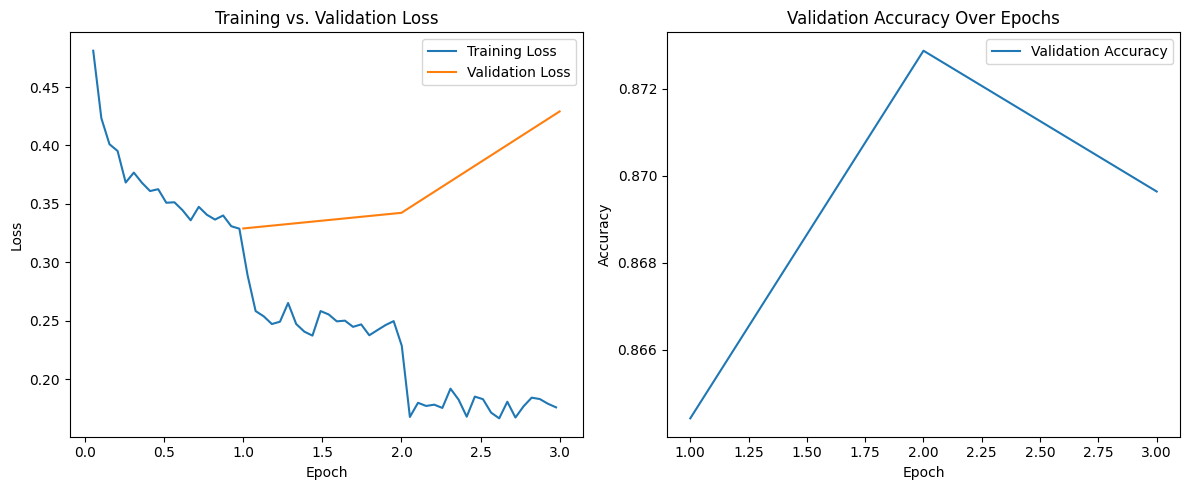


--- Final Evaluation on Test Set ---


{'eval_loss': 0.3289830982685089, 'eval_accuracy': 0.8644285310951978, 'eval_f1': 0.864633521271143, 'eval_precision': 0.8665433811064879, 'eval_recall': 0.8627320615762287, 'eval_runtime': 259.91, 'eval_samples_per_second': 149.902, 'eval_steps_per_second': 9.372, 'epoch': 3.0}

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.86     19408
    Positive       0.87      0.86      0.86     19553

    accuracy                           0.86     38961
   macro avg       0.86      0.86      0.86     38961
weighted avg       0.86      0.86      0.86     38961



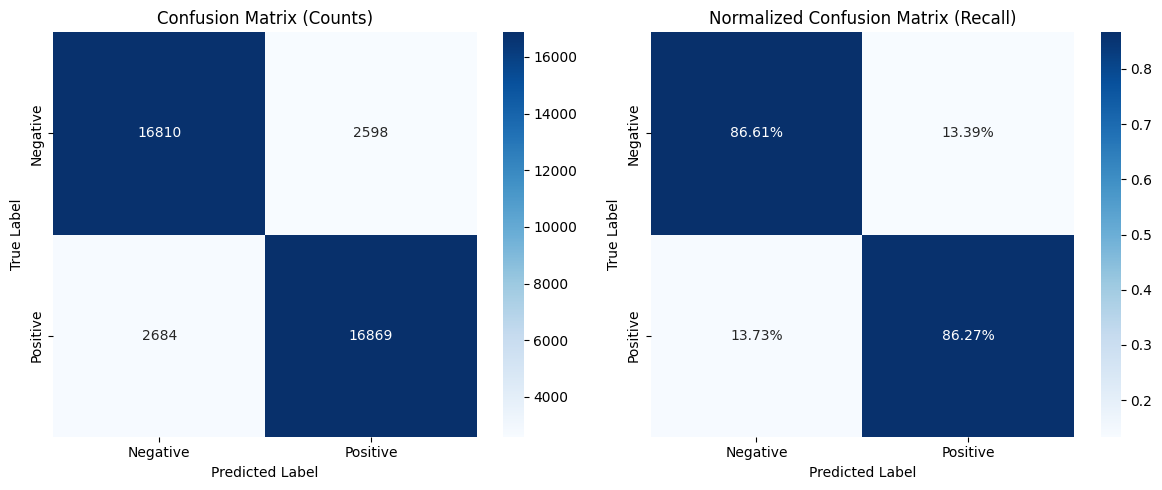

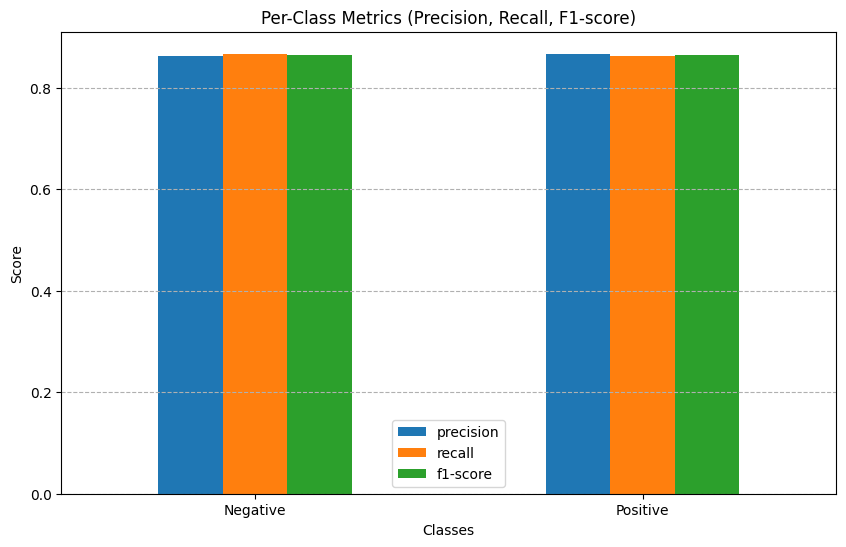


Model saved to /content/drive/MyDrive/THESIS 47/Saved Datasets/[Binary]fine-tuned_text_only


In [6]:
# --- EXTRACTING TRAINING HISTORY ---
log_history = trainer.state.log_history
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# --- 1. PLOTTING TRAINING VS VALIDATION LOSS & ACCURACY ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([log['epoch'] for log in train_logs], [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log['epoch'] for log in eval_logs], [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs. Validation Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot([log['epoch'] for log in eval_logs], [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy Over Epochs'); plt.legend()
plt.tight_layout(); plt.show()

# --- 2. FINAL EVALUATION ON TEST SET ---
print("\n--- Final Evaluation on Test Set ---")
eval_results = trainer.evaluate(); print(eval_results)
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_datasets["test"]["label"]

# --- 3. CLASSIFICATION REPORT ---
print("\n--- Classification Report ---")
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# --- 4. CONFUSION MATRICES ---
cm = confusion_matrix(true_labels, predicted_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix (Counts)')
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Normalized Confusion Matrix (Recall)')
plt.tight_layout(); plt.show()

# --- 5. PER-CLASS METRICS BAR CHART ---
report_df = pd.DataFrame(report).transpose()
metrics_df = report_df.loc[class_names]
metrics_df.plot(kind='bar', y=['precision', 'recall', 'f1-score'], figsize=(10, 6))
plt.title('Per-Class Metrics (Precision, Recall, F1-score)')
plt.xlabel('Classes'); plt.ylabel('Score'); plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--');
plt.show()

# --- 6. SAVING THE MODEL ---
output_model_path = "/content/drive/MyDrive/THESIS 47/Saved Datasets/[Binary]fine-tuned_text_only"
trainer.save_model(output_model_path)
print(f"\nModel saved to {output_model_path}")